In [48]:
# importing libraries
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import time
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from kneed import KneeLocator
from collections import Counter
from pyod.models.abod import ABOD
import operator
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import entropy
from sklearn.decomposition import PCA

In [49]:
# sampling the dataframe
def sampling(dataframe):
    """This function samples the large datasets to save time
    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    pandas dataframe
        returns the sampled dataframe
    """
    N = dataframe.shape[0]
    S = min(int(1000 * (np.log(N))),N)
    if(N != S):
        dataframe = dataframe.sample(n = S, replace = False, random_state=101)
    return dataframe

In [50]:
# Types of data from the dataframe
def datatype(dataframe):
    """This function returns the types of features in the given dataframe

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    string
        The string with information about the types of features in the given dataframe
    """
    # seperating the columns in the dataframe
    columns_list = dataframe.applymap(np.isreal).all()
    numeric_columns_list = dataframe.columns[columns_list].tolist()
    nonnumeric_column_list = dataframe.columns[~columns_list].tolist()
    # creating the strings with respective column names and showing them in a verbal output
    numeric_column_names = ', '.join(numeric_columns_list)
    nonnumeric_column_names = ', '.join(nonnumeric_column_list)
    if ((len(numeric_columns_list) != dataframe.shape[1]) and (len(nonnumeric_column_list) != dataframe.shape[1])):
        output = 'Both numerical and non-numerical. ' + \
            'The Numeric Column(s) is/are ' + numeric_column_names + ' respectively. ' + \
            'The Non-Numerical Column(s) is/are ' + nonnumeric_column_names + ' respectively.'
    elif(len(numeric_columns_list) == dataframe.shape[1]):
        output = 'only Numerical'
    else:
        output = 'Non Numerical'
    return output

In [51]:
# Dimensions of the dataframe
def dimensions(dataframe):
    """This function returns the dimensions of the given dataframe

    Parameters
    ----------
    dataframe : any pandas dataframe

    Returns
    -------
    output
        string output with the number of samples and features in the given dataframe
    """
    output = str(dataframe.shape[0])+' Row(s) and '+str(dataframe.shape[1])+' Column(s)'
    return output

In [52]:
# Checking for unique features in the dataset
def unique_features(dataframe):
    """This function checks for unique features in the given dataset

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    string
        gives the features that can be avoided initially
    """
    column_list = dataframe.columns.tolist()
    output_list = []
    output = ''
    useless_list = ['id', 'address', 'account']
    # removing unique rows from the dataset
    dataframe = dataframe.drop_duplicates()
    useless_list = ['id', 'address', 'account']
    for feature_name in column_list:
        unique_values = dataframe[[feature_name]].nunique()
        total_rows = dataframe[feature_name].shape[0]
        # if the feature contains only one value in the whole dataset then it is not needed
        if (unique_values[0] == 1):
            output_list.append(feature_name)
        # if the unique values are equal to the total number of rows of the column then they are unique
        # the name of the feature contains 'ID'
        elif ((unique_values[0] == total_rows) and (dataframe[feature_name].dtype == 'object')): #if the type is string and has many unique values
            output_list.append(feature_name)
        elif((unique_values[0] == total_rows) and (any(i in feature_name.lower() for i in useless_list))): # ID, Address Columns
            output_list.append(feature_name)
    output = ', '.join(output_list)
    if (output == ''):
        output = 'There are no UNIQUE column(s) in this Dataset.\n'
    else:
        output = 'The column(s) ' + output + ' is/are inconsistent and are advisable to avoid.\n'
    return output

In [53]:
# Checking Missing Values in the Dataset
def missing_features(dataframe):
    """This function checks the missing values, if any in the dataframe.
    As a thumb rule, we will usually remove missing values that contributes more than 10% of the whole dataset
    The ADVISER model assumes that there are no missing values and removes all the missing values.

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    string
        gives the features that contains the mising values
    """
    missing_columns_list = dataframe.columns[dataframe.isnull().any()]
    if(len(missing_columns_list) != 0):
        missing_values = dataframe.isnull().sum()
        missing_values_percent = 100 * dataframe.isnull().sum() / len(dataframe)
        missing = pd.concat([missing_values, missing_values_percent, dataframe.dtypes], axis=1)
        missing = missing.rename(columns = {0 : 'Missing Values', 1 : '% of Missing Values', 2 : 'Data Type'})
        missing = missing[missing.iloc[:,1] != 0].sort_values('Missing Values', ascending=False)
        output = str(missing.shape[0]) +" column(s) out of " + str(dataframe.shape[1]) + " column(s) that has missing values."
    else:
        output = 'None'
    return output

In [54]:
# Checking for duplicates in the rows
def duplicated(dataframe):
    """This function checks for any duplicated records.

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    string
        returns the number of duplicated rows in the dataframe
    """
    duplicated_rows = dataframe[dataframe.duplicated()]
    no_duplicated_rows = duplicated_rows.shape[0]
    if(no_duplicated_rows == 0):
        output = 'None'
    else:
        output = str(no_duplicated_rows) +\
        ' row(s) out of ' + str(dataframe.shape[0]) + ' row(s) are duplicated'
        print('\nThe row(s) that are duplicated:\n')
        display(duplicated_rows)
    return output

In [55]:
# removing the unique columns from the dataframe
def remove_unique(dataframe):
    """This function removes the unique values from the dataframe

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    dataframe
        the pandas dataframe without the unqiue values
    """
    # finding the unique columns from the dataset
    # getting all the columns as a list
    column_list = dataframe.columns.tolist()
    # removing duplicated rows from the dataset
    dataframe = dataframe.drop_duplicates()
    unique_list = []
    useless_list = ['id', 'account']
    # iterating through the dataset and getting the repeated values in each column
    for feature_name in column_list:
        unique_values = dataframe[[feature_name]].nunique()
        total_rows = dataframe[feature_name].shape[0]
        if ('datetime' in str(dataframe[feature_name].dtype)):
            unique_list.append(feature_name)
        # if the feature contains only one value in the whole dataset then it is not needed
        elif (unique_values[0] == 1):
            unique_list.append(feature_name)
        # if the unique values are equal to the total number of rows of the column then they are unique
        # the name of the feature contains 'ID'
        elif ((unique_values[0] == total_rows) and (dataframe[feature_name].dtype == 'object')): #if the type is string and has many unique values
            unique_list.append(feature_name)
        elif ((unique_values[0] == total_rows) and (any(i in feature_name.lower() for i in useless_list))): # ID, Address Columns
            unique_list.append(feature_name)
    # ADD SOME MORE CONDITIONS BASED ON REQUIREMENT AND ADD IN UNIQUE_LIST FOR REMOVAL OF COLUMNS removing the useless columns from the dataframe
    removed_dataframe = dataframe.drop(unique_list, axis=1)
    return removed_dataframe

In [56]:
# Correlation Matrix and Correlated features
def correlation(raw_dataframe,percent = 1):
    """This function finds the correlation of the dataframe returns the top correlated features

    Parameters
    ----------
    raw_dataframe : pandas dataframe
    percent : int, optional
        The percentage of top correlated features can be specified here, by default 1

    Returns
    -------
    string
        the top correlated features
    """
    # removing columns that are unique
    # dataframe = raw_dataframe
    dataframe = remove_unique(raw_dataframe)
    # preprocessing Converting Categorical data into Numeric Data
    dataframe = dataframe.apply(encoding_data)
    correlation_matrix = dataframe.corr()
    try:
        if(correlation_matrix.shape > (1,1)):
        # correlation_matrix.style.background_gradient(cmap='PuBu').set_precision(3)
        # the matrix is symmetric so we are extracting upper triangle matrix without diagonal (k = 1)
            sorted_values = (correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
            top_positive_percent_value = sorted_values.max() - ((percent/100) * sorted_values.max())
            top_negative_percent_value = sorted_values.min() - ((percent/100) * sorted_values.min())
            highly_positive_correlated = sorted_values[sorted_values > top_positive_percent_value]
            highly_negative_correlated = sorted_values[sorted_values < top_negative_percent_value]
            print('The Top positive', str(percent), '% correlation value is',str(top_positive_percent_value),\
        '. The Top Positively correlated features and their values are listed.\n',highly_positive_correlated)
            print('The Top negative', str(percent), '% correlation value is',str(top_negative_percent_value),\
        '. The Top Negatively correlated features and their values are listed.\n',highly_negative_correlated)    
            axes_heatmap = plt.axes()
            sns.heatmap(correlation_matrix, ax = axes_heatmap)
            axes_heatmap.set_title('Correlation Matrix')
            plt.show(sns)
        # visualizing the highest correlated features
            highest_positive_correlated_list = highly_positive_correlated.reset_index().values.tolist()
            print('\nThe features',str(highest_positive_correlated_list[0][0]),'and',str(highest_positive_correlated_list[0][1]),\
        'are the most positively correlated features with the value of',str(highest_positive_correlated_list[0][2]),'respectively.\n')
            highest_negative_correlated_list = highly_negative_correlated.reset_index().values.tolist()
            print('\nThe features',str(highest_negative_correlated_list[-1][0]),'and',str(highest_negative_correlated_list[-1][1]),\
        'are the most negatively correlated features with the value of',str(highest_negative_correlated_list[-1][2]),'respectively.\n')
            highest_correlated_list = highest_positive_correlated_list + highest_negative_correlated_list
            # print('The top positively and negatively correlated features are plotted.\n')
            # visualization(dataframe,highest_correlated_list)
            output = 'The correlation is done using the dataset.\n'
        else:
            output = 'The Correlation Matrix is not possible with this dataset.\n Please check the basic plot.\n'
            # dataframe.plot(title = 'Basic Plot from the Dataset')
    except:
        output = 'The Correlation Matrix is not possible with this dataset.\n'
    return output

In [57]:
# Encoding the non numerical columns
def encoding_data(dataframe):
    """The function checks whether the current feature in the dataframe is a numeria

    Parameters
    ----------
    dataframe : pandas dataframe
        any pandas dataframe object with both numerical and non numerical features

    Returns
    -------
    dataframe
        the dataframe with all the non numerical columns converted into numerical columns
    """
    if(dataframe.dtype == 'object'):
        return LabelEncoder().fit_transform(dataframe.astype(str))
    else:
        return dataframe

In [58]:
# finding the possible features that can be prediced from the dataset
def possible_features(raw_dataframe,n = 3):
    """This function automatically finds the features that can be predicted with higher accuracies

    Parameters
    ----------
    raw_dataframe : pandas dataframe
        The original dataframe for which the predictable features are to be found
    n : int, optional
        The number of top predictable features that should be returned, by default 3

    Returns
    -------
    pandas dataframe
        returns the dataframe with higher accuracy yielding features along with feature selection
    """
# n is the expected minimum accuracy percentage
    try:
        # removing unique columns
        # dataframe = raw_dataframe
        dataframe = remove_unique(raw_dataframe)
        features_dictionary = {}
        # preprocessing Converting Categorical data into Numeric Data
        dataframe = dataframe.apply(encoding_data)
        column_list = dataframe.columns.tolist()
        # Dropping Missing Values
        cdata = dataframe.dropna()
        k = math.floor(np.sqrt(dataframe.shape[0])) # sometimes it may create a problem
        # k = 10
        for i in column_list:
            try:
                # Seperating Input and Target Dataset
                selected_target_feature = i
                # input_dataframe = cdata.drop(columns=[selected_target_feature]).astype(int) 
                # target_dataframe = cdata[selected_target_feature].values.astype(int)
                # this conversion is creating problem
                input_dataframe = cdata.drop(columns=[selected_target_feature]) 
                target_dataframe = cdata[selected_target_feature]
                # Splitting the input and target data separately
                input_train, target_train, input_test, target_test = train_test_split(input_dataframe, target_dataframe, train_size=0.8, test_size=0.2, random_state=1)
                # Building the model
                KNN = KNeighborsRegressor(n_neighbors = k)
                # Training the model
                KNN.fit(input_train,input_test)
                # Calculating the accuracy
                accuracy = KNN.score(target_train,target_test)
            except:
                accuracy = 0
            features_dictionary[i]=accuracy
        #     sorting the dictionary
        # maximum_value = max(features_dictionary, key=features_dictionary.get)
        # maximum_equal_value = []
        # maximum_features = ''
        advisable_features_list = []
        # only top few features are needed.
        result = sorted(features_dictionary.items(), key = operator.itemgetter(1), reverse  = True)
        top_n = result[:n]
        print('The top',n,'features that can be predicted are:',top_n)
        for i in top_n:
            advisable_features_list.append(i[0])
        #condition - assuming the last feature as target
        last_feature = dataframe.columns[-1]
        if(last_feature not in advisable_features_list):
            print('\n\nThe feature',last_feature,'with the accuracy of',str(features_dictionary[last_feature]),\
                  'can also an advisable Target Feature(s) for this dataset.\n')
            advisable_features_list.append(last_feature)
        #condition ended
        feature_selected = feature_selection(dataframe,advisable_features_list)
        # display(feature_selected)
    except:
        return 'The Dataset is not fit for prediction.\n'

In [59]:
# Feature Selection using the selected Target Feature
def feature_selection(raw_dataframe, target_feature_list):
    """This function takes over the feature selection process for supervised learning algorithm

    Parameters
    ----------
    raw_dataframe : pandas dataframe
        The dataframe on which the feature selection has to be applied
    target_feature_list : list
        The list of features for which the important features has to be found.

    Returns
    -------
    pandas dataframe
        The dataframe containing the list of features along with their selected features
    """
    output_list = []
    # dataframe = raw_dataframe
    dataframe = remove_unique(raw_dataframe)
    # preprocessing Converting Categorical data into Numeric Data
    dataframe = dataframe.apply(encoding_data)
    column_list = dataframe.columns.tolist()
    dataframe = dataframe.dropna()
    for target in target_feature_list:
        target_feature = target
        x = dataframe.drop(columns=[target_feature])
        y = dataframe[target_feature].values
        # Lasso feature selection 
        estimator = LassoCV(cv = 3)
        featureselection = SelectFromModel(estimator)
        featureselection.fit(x,y)
        features = featureselection.transform(x)
        feature_list = x.columns[featureselection.get_support()]
        if(len(feature_list) == 0):
            estimator = LassoCV(cv = 3, normalize = True, )
            featureselection = SelectFromModel(estimator)
            featureselection.fit(x,y)
            features = featureselection.transform(x)
            feature_list = x.columns[featureselection.get_support()]
        features = ''
        for i in feature_list:
            if features == '':
                features = i
            else:
                features = features + ', ' + i
        if(features == ''):
            features = 'All the features are needed'
        l = (target,features)
        output_list.append(l)
    output_df = pd.DataFrame(output_list,columns = ['Name','Selected Features'])
    print('\nThe Feature Selection is done with the respective target feature(s)')
    print(output_df)
    return output_df

In [60]:
# clustering the dataframe using KMeans clustering.
def clustering(raw_dataframe, n = 5):
    """This function clusters the dataframe automatically

    Parameters
    ----------
    raw_dataframe : pandas dataframe
    n : int, optional
        The number of clusters, by default 5

    Returns
    -------
    string
        The number of optimal clusters along with their feature selection
    """
    try:
        # remvoing the columns that are unique
        # dataframe = raw_dataframe
        dataframe = remove_unique(raw_dataframe)
        # preprocessing Converting Categorical data into Numeric Data
        dataframe = dataframe.apply(encoding_data)
        column_list = dataframe.columns.tolist()
        # dropping missing values
        dataframe = dataframe.dropna()
        # scaling the data
        # CREATES PROBLEM WHILE DOING THE CENTROID PLOTTING AND CALCULATION
        # s_dataframe = scaling_data(dataframe)
        # dataframe = s_dataframe[0]
        # unscaled_dataframe = s_dataframe[1]
        # Applying KMeans Algorithm
        cost_points = []
        output = ''
        k_values = ''
        k_range = range(1,n)
        for k in k_range:
            kmeans_model = KMeans(n_clusters = k, random_state = 1).fit(dataframe.iloc[:,:])
            inertia = kmeans_model.inertia_
            k_values = k_values + '\nK = ' + str(k) + ' cost = ' + str(inertia)
            cost_points.append(inertia)
        # print('The dataset is clustered and the cost (squared error) value of each K number of clusters are given:\n', k_values)
        # visualizing the graph
        # finding the elbow point and optimal number of cluster
        kneedle = KneeLocator(list(k_range), cost_points, S = 1.0, curve = 'convex', direction = 'decreasing')
        optimal_cluster = kneedle.knee
        plt.plot(k_range,cost_points,'x-')
        plt.xlabel('K Value')
        plt.ylabel('Squared Error (cost)')
        plt.title('The Elbow Method - Showing the optimal K')
        plt.vlines(optimal_cluster, plt.ylim()[0], plt.ylim()[1],linestyles='dashed')
        plt.tight_layout()
        plt.show()
        print('\nBased on the Elbow Method, the optimal number of clusters for this dataset is',str(optimal_cluster),'.\n')
        # optimum KMeans Model
        optimum_kmeans_model = KMeans(n_clusters = optimal_cluster, random_state = 1).fit(dataframe.iloc[:,:])
        labels = optimum_kmeans_model.labels_
        print('\nKeeping the optimum value of K =', str(optimal_cluster),
              ', the Dataset is clustered and the size of each cluster is given in the counter:\n',str(Counter(labels)))
        # Feature Selection for Clustering algorithm
        print('The Feature Selection for clustering is done: The Required features are shown below:')
        output = low_variance_filter_clustering(dataframe)
    except ValueError as e:
        if (str(e) == 'min() arg is an empty sequence'):
            print('Please increase the minimum number of clusters to calculate the optimal cluster.')
    except:
        output = 'The Clustering is not possible with this dataset.\n'
    return output

In [61]:
# Feature Selection for Clustering
def low_variance_filter_clustering(raw_dataframe):
    """The feature selection for unsupervised clustering

    Parameters
    ----------
    raw_dataframe : pandas dataframe

    Returns
    -------
    string
        features that contribute the clusters
    """
    # remvoing the columns that are unique
    dataframe = remove_unique(raw_dataframe)
    # preprocessing Converting Categorical data into Numeric Data
    dataframe = dataframe.apply(encoding_data)
    # removing the NaN values
    dataframe = dataframe.dropna()
    # Applying the variance threshold function with 0 threshold
    feature_selection = VarianceThreshold(threshold = 0.0)
    feature_selection.fit(dataframe)
    # calculating the threshold of first 25% of the values. Median / 2
    threshold = np.median(feature_selection.variances_) / 2
    # selecting only the features that are above the calculated threshold
    selected_features = dataframe.columns.values[feature_selection.variances_ > threshold]
    features = ''
    for i in selected_features.tolist():
        if features == '':
            features = i
        else:
            features = features + ', ' + i
    return features

DCCD Algorithm

In [62]:
# function to calculate entropy
def calculate_entropy(dataframe):
    """This function calculates the entropy of each and every feature in the dataframe

    Parameters
    ----------
    dataframe : pandas dataframe

    Returns
    -------
    pandas dataframe
        a dataframe with all the corresponding entropies
    """
    df = pd.DataFrame({'name':dataframe.columns.values, 'entropy':entropy(dataframe)})
    df = df.set_index('name')
    return df

In [63]:
# function to discretize the entropy dataframe
def cluster_entropy(entropy_dataframe):
    """This function clusters the entropy dataframe into optimal number of clusters.

    Parameters
    ----------
    entropy_dataframe : pandas dataframe
        The entropy dataframe which contains all the features along with their entropies

    Returns
    -------
    pandas dataframe
        dataframe with respective clusters is returned
    """
    clusters_dataframe = pd.DataFrame()
    cost_points = []
    k_range = range(1, 10) # can be specified manually by the user
    for k in k_range:
        kmeans_model = KMeans(n_clusters = k, random_state = 1).fit(entropy_dataframe)
        inertia = kmeans_model.inertia_
        cost_points.append(inertia)
    kneedle = KneeLocator(list(k_range), cost_points, S = 1.0, curve = 'convex', direction = 'decreasing')
    optimal_cluster = kneedle.knee
    #adding a feature cluster in the dataframe
    optimum_kmeans_model = KMeans(n_clusters = optimal_cluster, random_state = 1).fit(entropy_dataframe)
    labels = optimum_kmeans_model.labels_
    clusters_dataframe = entropy_dataframe.copy()
    clusters_dataframe.insert(len(clusters_dataframe.columns), 'clusters', labels)
    return clusters_dataframe

In [64]:
# function to convert the clustered features into dataframes. each dataframe contains similar features
def batching_process(clustered_entropy, orginal_dataframe):
    """This function converts the clusters having entropies into batches with values from the original dataframe

    Parameters
    ----------
    clustered_entropy : pandas dataframe
        The clustered dataframe with entropies
    orginal_dataframe : pandas dataframe
        The original dataframe

    Returns
    -------
    dictionary
        dictionary containing batches
    """
    # getting the clusters and forming batchs
    number_of_batchs = clustered_entropy['clusters'].nunique()
    # creating a list of lists of features associated to each batch
    batch_list = []
    for i in range(number_of_batchs):
        batch_features = clustered_entropy[clustered_entropy['clusters'] == i].index.tolist()
        batch_list.append(batch_features)
    # creating batchs dataframes in a dictionary
    batch_dict = {i:orginal_dataframe[columns] for i, columns in enumerate(batch_list)}
    return batch_dict

In [65]:
# function to convert the batchs into principal components
def batch_to_pca(batch_dictionary):
    """This function converts all the batches into Principal Components

    Parameters
    ----------
    batch_dictionary : Dictionary
        The dictionary which we got from the batching_process() function

    Returns
    -------
    pandas dataframe
        The dimension reduced dataframe is returned
    """
    pca_items = batch_dictionary
    pca = PCA(n_components = 1)
    pca_list = []
    for i in range(len(batch_dictionary)):
        pca_items[i] = pca.fit_transform(pca_items[i])
        pca_items[i] = pd.DataFrame(pca_items[i], columns = ['principal_component_' + str(i)])
        pca_list.append(pca_items[i])
    pca_dataframe = pd.concat(pca_list, axis = 1)
    return pca_dataframe

In [66]:
# finding the highest value returning feature
def highest_accuracy_target(dataframe):
    """This function finds the highest accuracy returning principal component from the dimensionally reduced dataframe

    Parameters
    ----------
    dataframe : pandas dataframe
        The dimensionally reduced dataframe

    Returns
    -------
    string
        Returns the principal component which returns the highest component
    """
    column_list = dataframe.columns.tolist()
    accuracy_list = []
    features_dictionary = {}
    k = math.floor(np.sqrt(dataframe.shape[0])) # sometimes it may cause some problems
    for i in column_list:
        selected_target_feature = i
        input_df = dataframe.drop(columns = selected_target_feature, axis = 1)
        target_df = dataframe[selected_target_feature]
        input_train, target_train, input_test, target_test = train_test_split(input_df, target_df, train_size=0.8, test_size=0.2, random_state=1)
        KNN = KNeighborsRegressor(n_neighbors = k)
        KNN.fit(input_train,input_test)
        accuracy = KNN.score(target_train,target_test)
        features_dictionary[i]=accuracy
    sorted_dictionary  = sorted(features_dictionary.items(), key = operator.itemgetter(1), reverse  = True)
    # print(sorted_dictionary)
    maximum_value = max(features_dictionary, key=features_dictionary.get)
    return maximum_value

In [67]:
# finding the highest value returning feature but, at the last step - include all the features
def highest_accuracy_target_last(dataframe, columns, n):
    """This function takes care of the last feature. 
    (assumption here is the last feature is generally the target feature)

    Parameters
    ----------
    dataframe : pandas dataframe
    columns : list
        The columns from the original big dataframe
    n : int
        The number of features to show

    Returns
    -------
    dictionary
        The accuracy of the last feature
    """
    accuracy_list = []
    features_dictionary = {}
    k = math.floor(np.sqrt(dataframe.shape[0])) # sometimes it may cause some problems
    for i in columns:
        selected_target_feature = i
        input_df = dataframe.drop(columns = selected_target_feature, axis = 1)
        target_df = dataframe[selected_target_feature]
        input_train, target_train, input_test, target_test = train_test_split(input_df, target_df, train_size=0.8, test_size=0.2, random_state=1)
        KNN = KNeighborsRegressor(n_neighbors = k)
        KNN.fit(input_train,input_test)
        accuracy = KNN.score(target_train,target_test)
        features_dictionary[i]=accuracy
    sorted_dictionary  = sorted(features_dictionary.items(), key = operator.itemgetter(1), reverse  = True)
    # print(sorted_dictionary)
    top_n = sorted_dictionary[:n]
    return top_n

In [68]:
# keeping all the logic in the algorithm
def dccd_algorithm(dataframe, n = 3):
    """This function consolidates all the logics for the DCCD algorithm

    Parameters
    ----------
    dataframe : pandas dataframe
    n : int, optional
        The number of features to show, by default 3

    Returns
    -------
    pandas dataframe
        The top number of features that can be predicted with higher accuracies are shown
    """
    dataframe = dataframe.dropna()
    dataframe = dataframe.apply(encoding_data)
    dataframe = remove_unique(dataframe)
    orginal_dataframe = dataframe.copy()
    target_found = 'NO'
    while(target_found == 'NO'):
        # if the features of the dataframe are greater than a particular number
        if(len(dataframe.columns) > 20):
            # calculating entropy first
            entropy_dataframe = calculate_entropy(dataframe)
            # clustering based on entropy
            clustered_entropy = cluster_entropy(entropy_dataframe)
            # batching process (discretization of the dataframe)
            batched_dictionary = batching_process(clustered_entropy, dataframe)
            # convert the batchs into principal components
            pca_items = batched_dictionary.copy()
            dataframe = batch_to_pca(pca_items)
        else:
            dataframe = dataframe
        # if there is just 1 feature in the dataframe (just in case)
        if(len(dataframe.columns) == 1):
            target = dataframe.columns[0]
        else:
            target = highest_accuracy_target(dataframe)
        # de-discretization of principal components
        if(target.startswith('principal_component_')):
            batch_number = int(target[-1])
            dataframe = batched_dictionary[batch_number]
        else:
            target = highest_accuracy_target_last(orginal_dataframe, dataframe.columns.tolist(), n)
            target_found = 'YES'
        # output = 'suggested target features = ' + target
        # after finding the target, assuming the last feature as target feature
        if (target_found == 'YES'):
            last_feature = orginal_dataframe.columns[-1]
            # if this feature not in the suggested target list
            flag = 0
            for i in target:
                if (last_feature == i[0]):
                    flag = 1
            if (flag == 0):    
                print('Another possiblity = ', highest_accuracy_target_last(orginal_dataframe, [last_feature], 1))
    return target

In [69]:
# Mother Model here
def adviser(dataframe):
    """The ADVISER model is coded here. It consolidates all the above logics and function.

    Parameters
    ----------
    dataframe : pandas dataframe
    """
    # sampling the large datasets
    sampled_dataframe = sampling(dataframe)

    # Automatic Data Understanding Phase
    # data type analysis
    print(datatype(dataframe))
    # finding the number of samples and features for the whole dataframe
    print(dimensions(dataframe = dataframe))
    # finding the unique features for the whole dataframe
    print(unique_features(dataframe))
    # Check missing values in the dataframe
    print(missing_features(dataframe))
    # Check for duplicated records in the dataframe
    print(duplicated(dataframe))
    # Outlier detection in the model has been removed due to technical lagging issue
    # room for future work
    # Checking the correlation
    print(correlation(dataframe, percent = 1))  # users can specify the top correlation percentage

    # Automatic Supervised Learning Phase
    if(dataframe.shape[1] > 200):
        # DCCD algorithm will get triggered here
        sampled_dataframe = sampled_dataframe.dropna()
        print(dccd_algorithm(sampled_dataframe, n = 3)) # users can specify the top number of features
    else:
        print(possible_features(sampled_dataframe, n = 3)) # users can specify the top number of features
    
    # Automatic Unsupervised Learning Phase
    print(clustering(sampled_dataframe, n = 10)) # users can specify the total number of clusters based on their system hardware
    print('Thank you for using ADVISER!')

Both numerical and non-numerical. The Numeric Column(s) is/are id, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, fractal_dimension_worst respectively. The Non-Numerical Column(s) is/are diagnosis respectively.
569 Row(s) and 32 Column(s)
The column(s) id is/are inconsistent and are advisable to avoid.

None
None
The Top positive 1 % correlation value is 0.9878767286788728 . The Top Positively correlated features and their values are listed.
 radius_mean   perimeter_mean     0.997855
radius_worst  perimeter_worst    0.993708
dtype: float64
The Top negative 1 % correlation value is

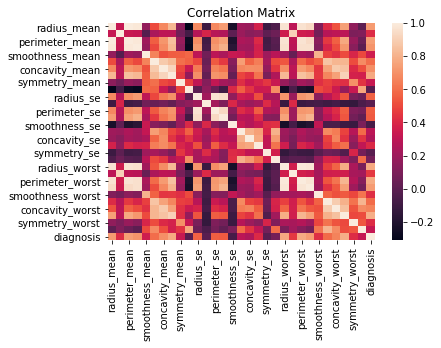


The features radius_mean and perimeter_mean are the most positively correlated features with the value of 0.9978552814938109 respectively.


The features radius_mean and fractal_dimension_mean are the most negatively correlated features with the value of -0.3116308263092899 respectively.

The correlation is done using the dataset.

The top 3 features that can be predicted are: [('radius_worst', 0.9851215294595748), ('perimeter_mean', 0.9708111771046166), ('radius_mean', 0.9696476968025103)]


The feature diagnosis with the accuracy of 0.6939943589281963 can also an advisable Target Feature(s) for this dataset.


The Feature Selection is done with the respective target feature(s)
             Name                                      Selected Features
0  radius_worst    area_mean, area_se, perimeter_worst, area_worst      
1  perimeter_mean  area_mean, area_se, perimeter_worst, area_worst      
2  radius_mean     area_mean, area_se, perimeter_worst, area_worst      
3  diagnosis       

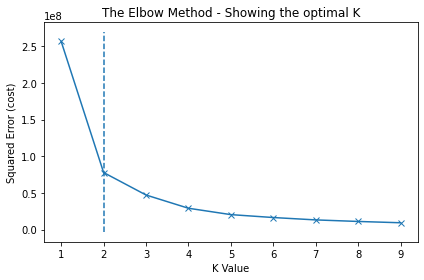


Based on the Elbow Method, the optimal number of clusters for this dataset is 2 .


Keeping the optimum value of K = 2 , the Dataset is clustered and the size of each cluster is given in the counter:
 Counter({0: 438, 1: 131})
The Feature Selection for clustering is done: The Required features are shown below:
radius_mean, texture_mean, perimeter_mean, area_mean, concavity_mean, radius_se, texture_se, perimeter_se, area_se, radius_worst, texture_worst, perimeter_worst, area_worst, compactness_worst, concavity_worst, concave points_worst, symmetry_worst, diagnosis
Thank you for using ADVISER!


In [70]:
small_data = pd.read_csv('Datasets\Breast Cancer Winconsin.csv')
big_data = pd.read_csv('Datasets\Synthetic_Dataset_500_1000.csv')

adviser(small_data)